## Feature Scaling & Normalization with Heart Disease

### Imports & Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

# Load dataset from OpenML (Heart Disease dataset ID = 53)
data = fetch_openml(name="heart-disease", version=1, as_frame=True)
df = data.frame

print(df.head())
print(df.info())

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  3.0     145.0  233.0  1.0      0.0    150.0    0.0      2.3   
1  37.0  1.0  2.0     130.0  250.0  0.0      1.0    187.0    0.0      3.5   
2  41.0  0.0  1.0     130.0  204.0  0.0      0.0    172.0    0.0      1.4   
3  56.0  1.0  1.0     120.0  236.0  0.0      1.0    178.0    0.0      0.8   
4  57.0  0.0  0.0     120.0  354.0  0.0      1.0    163.0    1.0      0.6   

   slope   ca  thal  target  
0    0.0  0.0   1.0     1.0  
1    0.0  0.0   2.0     1.0  
2    2.0  0.0   2.0     1.0  
3    2.0  0.0   2.0     1.0  
4    2.0  0.0   2.0     1.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303

In [4]:
print(df.columns)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


### Preprocessing

In [5]:
# Features & target
X = df.drop("target", axis=1)
y = df["target"].astype(int)  # target is 0/1

# Identify categorical & numerical features
cat_features = X.select_dtypes(include=["category", "object"]).columns.tolist()
num_features = X.select_dtypes(exclude=["category", "object"]).columns.tolist()

print("Categorical features:", cat_features)
print("Numerical features:", num_features)

# One-hot encode categorical features (if any exist)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer([
    ("onehot", OneHotEncoder(drop="first", sparse_output=False), cat_features),
    ("num", "passthrough", num_features)
])

X_encoded = ct.fit_transform(X)

# Raw (unscaled)
X_raw = X_encoded

# Standardized
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X_encoded)

# MinMax Normalized
scaler_mm = MinMaxScaler()
X_norm = scaler_mm.fit_transform(X_encoded)

# Train-test split
from sklearn.model_selection import train_test_split
X_raw_train, X_raw_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)
X_std_train, X_std_test, _, _ = train_test_split(X_std, y, test_size=0.2, random_state=42)
X_norm_train, X_norm_test, _, _ = train_test_split(X_norm, y, test_size=0.2, random_state=42)

print("Shapes:", X_raw_train.shape, y_train.shape)

Categorical features: []
Numerical features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Shapes: (242, 13) (242,)


### Neural Network Factory

In [10]:
from tensorflow.keras import models, layers, optimizers

def build_model(input_dim, learning_rate=0.001):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(32, activation="relu")(inputs)
    x = layers.Dense(16, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

### Train on Raw, Standardized, Normalized

In [11]:
results = {}
histories = {}

# Raw data
model_raw = build_model(X_raw_train.shape[1])
history_raw = model_raw.fit(X_raw_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
results["Raw"] = model_raw.evaluate(X_raw_test, y_test, verbose=0)
histories["Raw"] = history_raw

# Standardized data
model_std = build_model(X_std_train.shape[1])
history_std = model_std.fit(X_std_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
results["Standardized"] = model_std.evaluate(X_std_test, y_test, verbose=0)
histories["Standardized"] = history_std

# Normalized data
model_norm = build_model(X_norm_train.shape[1])
history_norm = model_norm.fit(X_norm_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
results["Normalized"] = model_norm.evaluate(X_norm_test, y_test, verbose=0)
histories["Normalized"] = history_norm

print("Final Results (loss, accuracy):")
for k, v in results.items():
    print(f"{k}: Loss={v[0]:.4f}, Accuracy={v[1]:.4f}")

Final Results (loss, accuracy):
Raw: Loss=0.5933, Accuracy=0.7377
Standardized: Loss=0.3530, Accuracy=0.9016
Normalized: Loss=0.4505, Accuracy=0.7705


### Evaluate with Accuracy, Precision, Recall

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate_model(model, X_test, y_test, name):
    preds = model.predict(X_test, verbose=0)  
    preds = (preds > 0.5).astype(int)
    
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    print(f"{name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")
    return acc, prec, rec

metrics_summary = {}
metrics_summary["Raw"] = evaluate_model(model_raw, X_raw_test, y_test, "Raw Data")
metrics_summary["Standardized"] = evaluate_model(model_std, X_std_test, y_test, "Standardized Data")
metrics_summary["Normalized"] = evaluate_model(model_norm, X_norm_test, y_test, "Normalized Data")

Raw Data - Accuracy: 0.7377, Precision: 0.7353, Recall: 0.7812
Standardized Data - Accuracy: 0.9016, Precision: 0.9333, Recall: 0.8750
Normalized Data - Accuracy: 0.7705, Precision: 0.8750, Recall: 0.6562


### Compare Convergence

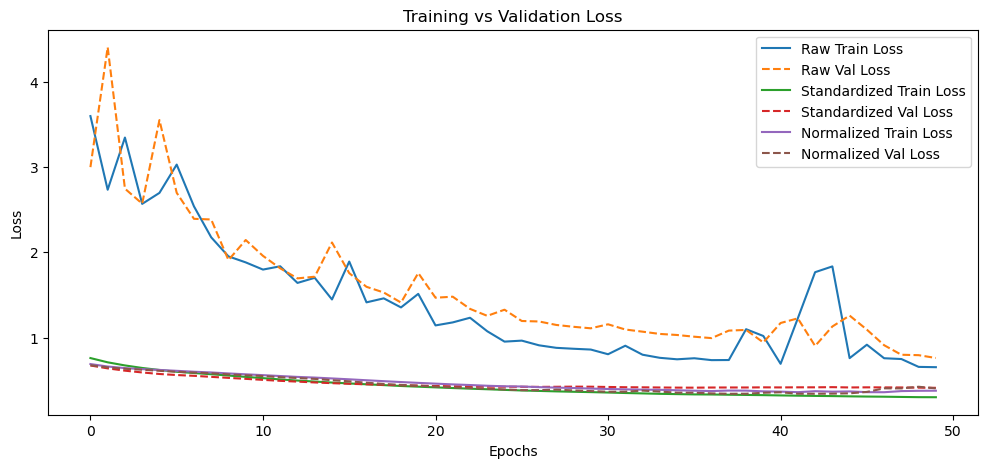

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
for name, history in histories.items():
    plt.plot(history.history["loss"], label=f"{name} Train Loss")
    plt.plot(history.history["val_loss"], label=f"{name} Val Loss", linestyle="--")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Sensitivity to Learning Rate

In [15]:
learning_rates = [0.001, 0.01, 0.1]
for lr in learning_rates:
    print(f"\n=== Training with learning rate = {lr} on Standardized Data ===")
    model_lr = build_model(X_std_train.shape[1], learning_rate=lr)
    history_lr = model_lr.fit(X_std_train, y_train, validation_split=0.2, epochs=30, batch_size=32, verbose=0)
    evaluate_model(model_lr, X_std_test, y_test, f"Standardized (lr={lr})")


=== Training with learning rate = 0.001 on Standardized Data ===
Standardized (lr=0.001) - Accuracy: 0.8525, Precision: 0.8966, Recall: 0.8125

=== Training with learning rate = 0.01 on Standardized Data ===
Standardized (lr=0.01) - Accuracy: 0.8361, Precision: 0.8438, Recall: 0.8438

=== Training with learning rate = 0.1 on Standardized Data ===
Standardized (lr=0.1) - Accuracy: 0.8197, Precision: 0.8387, Recall: 0.8125
